# Predicting the IMDb rating of Arrow (American TV Serie) through scripts
## From the site: https://subslikescript.com/ 
## by: Anna Luiza Gomes

# Obs:
## 1. O primeiro jupyter notebook se refere ao webscraping dos scripts e a associacao a topicos de forma nao supervisionada usando LDA (este arquivo), o segundo se refere ao webscraping da pagina da serie no Wikipedia para obter a informacao de quantos users viram a serie e seus diretores e por último, a montagem do dataset final com o objetivo de obter o rating do IMBd de cada episodio.

## 2. Como próximo passo pretendo refinar o modelo LDA e aplicar Lemmatização e Stemização na etapa de pré-processamento dos dados, pois ainda nao consegui devido a erros que nao consegui solucionar. Também pretendo entender e melhorar o algoritmo de CART que no desenvolvimento final deu erro.  

## 3. Irei continuar o estudo de LDA e aprimorar o paper com mais base teórica e trabalhos de referencia...como mudei muito de caminho ao longo do desenvolvimento certos artigos nao seriam mais relevantes ao trabalho, por isso a parte textual nao esta muito desenvolvida.

## 4. Estou fazendo este trabalho no github, se quiser posso disponibilizar o link tambem. Como nao está pronto, o repositorio esta fechado, mas ai pode me mandar um email (annalgs@id.uff.br) ou mensagem (992043770) que encaminho o link.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

In [ ]:
# configuração para não exibir os warnings

import warnings
warnings.filterwarnings("ignore")

# ignorando future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scripts = pd.read_csv('/content/drive/MyDrive/Trabalho Monografia PUC RIO/scripts.csv', sep=";")

In [ ]:
scripts.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
scripts.head()

,nome_ep,Episodios,text_processed,0,1,2,nota_imdb,qtd_reviews,Topic
0,/series/Arrow-2193021/season-1/episode-1-Pilot,The name of the islandthey found me on is Lian...,the name of the islandthey found me on is lian...,0.287473,0.652349,0.060177,8.5,7572,1
1,/series/Arrow-2193021/season-1/episode-2-Honor...,[PANTING][GRUNTS][SPEAKING IN FOREIGN LANGUAGE...,[panting][grunts][speaking in foreign language...,0.735218,0.034977,0.229805,8.2,5731,0
2,/series/Arrow-2193021/season-1/episode-3-Lone_...,"My name is Oliver Queen.To my family, I am the...",my name is oliver queen to my family i am the...,0.025055,0.160141,0.814804,8.4,5367,2
3,/series/Arrow-2193021/season-1/episode-4-An_In...,"My name is Oliver Queen.For 5 years, I was str...",my name is oliver queen for 5 years i was str...,0.100796,0.415217,0.483987,8.3,5071,2
4,/series/Arrow-2193021/season-1/episode-5-Damaged,"OLIVER:My name is Oliver Queen.For five years,...",oliver:my name is oliver queen for five years ...,0.755971,0.149650,0.094378,8.6,5011,0


In [ ]:
scripts.shape

(165, 9)

In [ ]:
wiki = pd.read_csv('/content/drive/MyDrive/Trabalho Monografia PUC RIO/wikipedia.csv', sep=";")

In [ ]:
wiki.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# the script is missing the episodes 12,13,14 from season 7 and episode 4 from season 3
# plus episode 18 from season 2 which is in portuguese
wiki.loc[[40,49,149,150,151]]  

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,Prod.code,U.S. viewers(millions)
40,41,18,"""Deathstroke""",Guy Bee,Marc Guggenheim & Drew Z. Greenberg,"April 2, 2014",2J7468,2.32[49]
49,50,4,"""The Magician""",John Behring,Marc Guggenheim & Wendy Mericle,"October 29, 2014",3J5154,2.49[58]
149,150,12,"""Emerald Archer""",Glen Winter,Marc Guggenheim & Emilio Ortega Aldrich,"February 4, 2019",T27.13662,1.07[159]
150,151,13,"""Star City Slayer""",Gregory Smith,Beth Schwartz & Jill Blankenship,"February 11, 2019",T27.13663,1.09[160]
151,152,14,"""Brothers & Sisters""",Marcus Stokes,Rebecca Bellotto & Jeane Wong,"March 4, 2019",T27.13664,0.89[161]


In [ ]:
wiki = wiki.drop(wiki.index[[40,49,149,150,151]]) #removing line 40

In [ ]:
wiki = wiki.reset_index(drop=True)

In [ ]:
wiki.shape

(165, 8)

In [ ]:
dataset = pd.concat([wiki, scripts], axis=1) 

In [ ]:
dataset.columns

Index(['No.overall', 'No. inseason', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'U.S. viewers(millions)', 'nome_ep',
       'Episodios', 'text_processed', '0', '1', '2', 'nota_imdb',
       'qtd_reviews', 'Topic'],
      dtype='object')

In [ ]:
dataset[['viewers(millions)','residual']] = dataset['U.S. viewers(millions)'].str.split('[',expand=True)

In [ ]:
dataset.drop(['U.S. viewers(millions)','residual','Title','text_processed','nome_ep','Topic','Episodios', 'No.overall', 'No. inseason', 'Written by', 'Prod.code', 'Original air date'], axis = 1 ,inplace = True)

In [ ]:
dataset = dataset[[ 'Directed by', 'qtd_reviews', '0','1','2', 'viewers(millions)',  'nota_imdb']]

In [ ]:
dataset.columns = ['Directed_by',  'qtd_reviews', '0','1','2','viewers(millions)',  'nota_imdb']

In [ ]:
dataset.head()

,Directed_by,qtd_reviews,0,1,2,viewers(millions),nota_imdb
0,David Nutter,7572,0.287473,0.652349,0.060177,4.14,8.5
1,David Barrett,5731,0.735218,0.034977,0.229805,3.55,8.2
2,Guy Bee,5367,0.025055,0.160141,0.814804,3.51,8.4
3,Vince Misiano,5071,0.100796,0.415217,0.483987,3.05,8.3
4,Michael Schultz,5011,0.755971,0.149650,0.094378,3.75,8.6


In [ ]:
dataset["viewers(millions)"] = pd.to_numeric(dataset["viewers(millions)"])

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    object 
 1   qtd_reviews        165 non-null    int64  
 2   0                  165 non-null    float64
 3   1                  165 non-null    float64
 4   2                  165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   nota_imdb          165 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 9.1+ KB


In [ ]:
columns_dataset = ['Directed_by','reviews', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'viewers(millions)', 'IMDB rating'  ]
dataset.columns = columns_dataset

## Data discovery

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# definindo a transformação ordinal encoding
encoder = OrdinalEncoder()

# transformando os dados
dataset[["Directed_by"]] = encoder.fit_transform(dataset[["Directed_by"]])

In [ ]:
dataset.head()

,Directed_by,reviews,Cluster 0,Cluster 1,Cluster 2,viewers(millions),IMDB rating
0,9.0,7572,0.287473,0.652349,0.060177,4.14,8.5
1,7.0,5731,0.735218,0.034977,0.229805,3.55,8.2
2,18.0,5367,0.025055,0.160141,0.814804,3.51,8.4
3,49.0,5071,0.100796,0.415217,0.483987,3.05,8.3
4,40.0,5011,0.755971,0.149650,0.094378,3.75,8.6


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    float64
 1   reviews            165 non-null    int64  
 2   Cluster 0          165 non-null    float64
 3   Cluster 1          165 non-null    float64
 4   Cluster 2          165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   IMDB rating        165 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 9.1 KB


In [ ]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Directed_by,165.0,25.375758,13.623577,0.000000,16.000000,22.000000,37.000000,50.000000
reviews,165.0,3471.806061,1449.607428,1370.000000,2239.000000,3355.000000,4355.000000,11347.000000
Cluster 0,165.0,0.349991,0.345814,0.011389,0.057808,0.209685,0.564207,0.999754
Cluster 1,165.0,0.529292,0.339187,0.000000,0.235339,0.588395,0.847322,0.986403
Cluster 2,165.0,0.119438,0.201370,0.000000,0.000000,0.026421,0.116258,0.946858
viewers(millions),165.0,2.113758,0.858646,0.620000,1.340000,2.270000,2.800000,4.140000
IMDB rating,165.0,8.323636,0.639635,5.500000,8.000000,8.300000,8.700000,9.700000


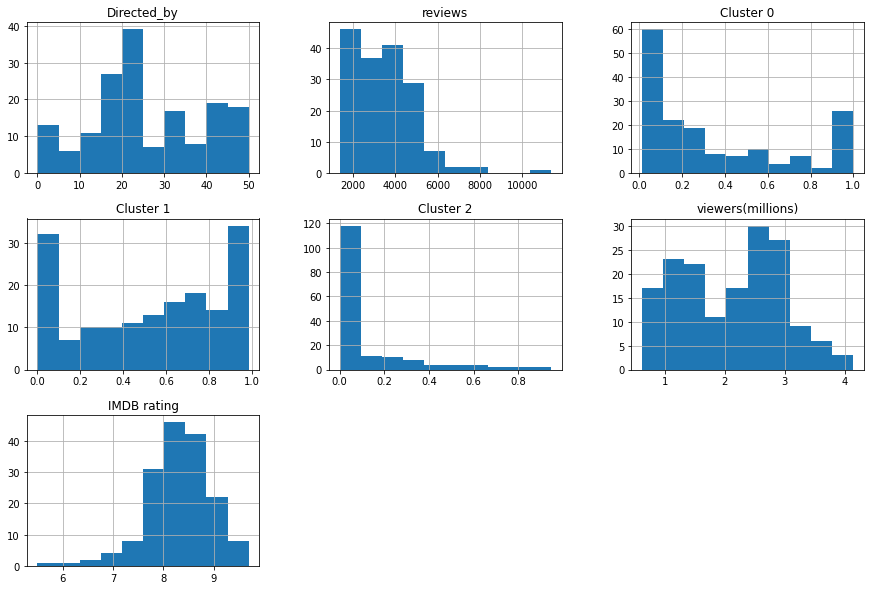

In [ ]:
dataset.hist(figsize = (15,10))
plt.show()

Text(0, 0.5, 'Frequency')

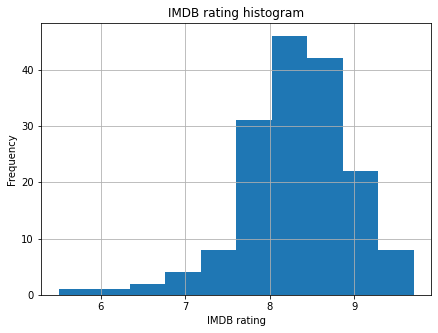

In [ ]:
dataset['IMDB rating'].hist(figsize=(7,5))
plt.title('IMDB rating histogram')
plt.xlabel('IMDB rating')
plt.ylabel('Frequency')

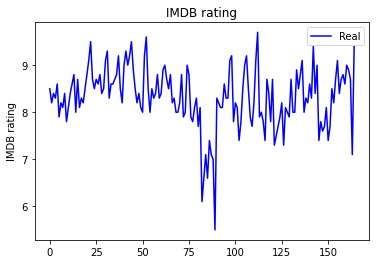

In [ ]:
plt.plot(dataset['IMDB rating'], color = 'blue', label = 'Real')
#plt.plot(pred, color = 'red', label = 'Previsto kNN k=8')
plt.title('IMDB rating')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

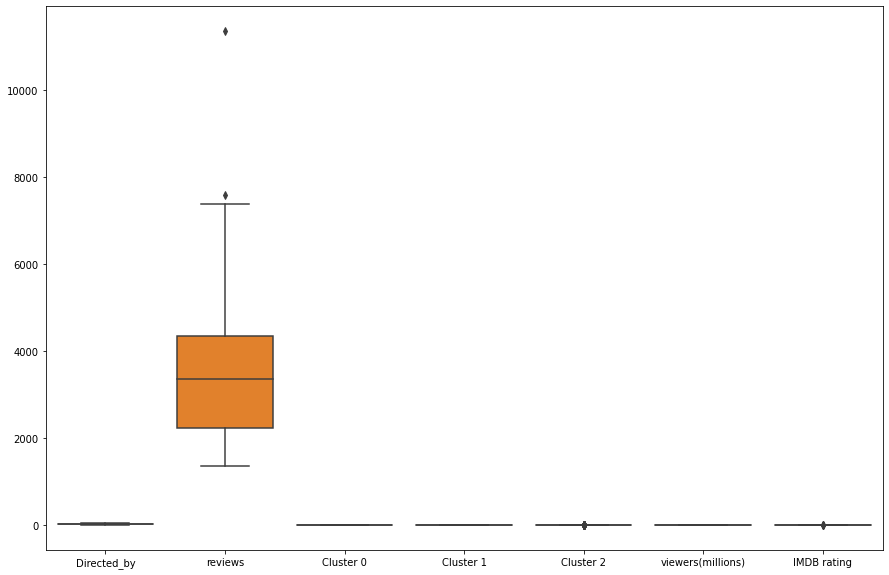

In [ ]:
import seaborn as sns
# boxplot com seaborn

fig, ax = plt.subplots(1, figsize= (15,10))
sns.boxplot(ax = ax, data = dataset)

Necessidade de normalizar o Directed_by, qtd_reviews e viewers(millions)

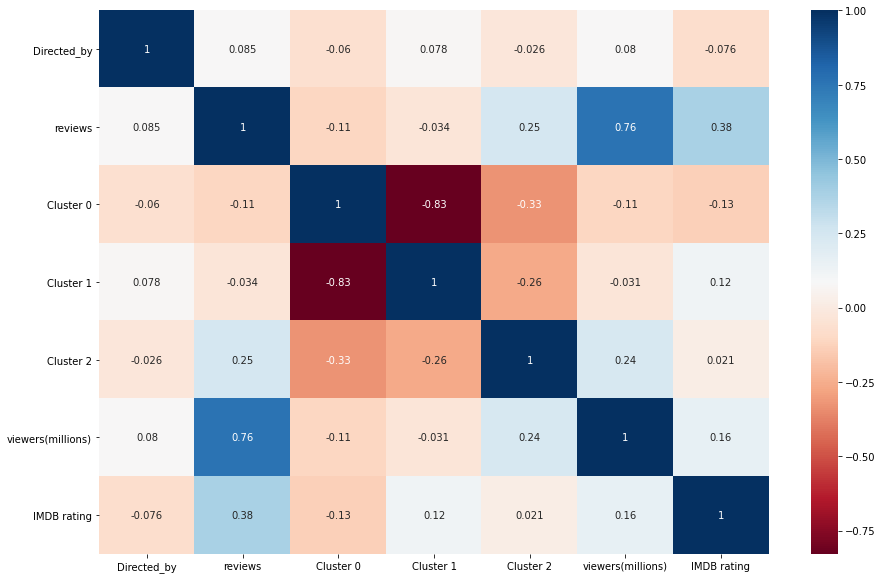

In [ ]:
#Heat map - pela correlação de pearson
fig, ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(dataset.corr(),ax=ax, annot=True, cmap='RdBu')

In [ ]:
from sklearn.preprocessing import MinMaxScaler  
#primeiro fazer uma normalização em todo dataset e depois da para fazer testes com os 2 datasets
dataset_scaler = MinMaxScaler()

rescaled_dataset = dataset_scaler.fit_transform(dataset)
rescaled_dataset = pd.DataFrame(rescaled_dataset, columns = columns_dataset) 

In [ ]:
rescaled_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Directed_by,165.0,0.507515,0.272472,0.0,0.320000,0.440000,0.740000,1.0
reviews,165.0,0.210665,0.145295,0.0,0.087100,0.198958,0.299188,1.0
Cluster 0,165.0,0.342588,0.349885,0.0,0.046965,0.200631,0.559326,1.0
Cluster 1,165.0,0.536588,0.343863,0.0,0.238583,0.596505,0.859001,1.0
Cluster 2,165.0,0.126142,0.212672,0.0,0.000000,0.027904,0.122782,1.0
viewers(millions),165.0,0.424363,0.243934,0.0,0.204545,0.468750,0.619318,1.0
IMDB rating,165.0,0.672294,0.152294,0.0,0.595238,0.666667,0.761905,1.0


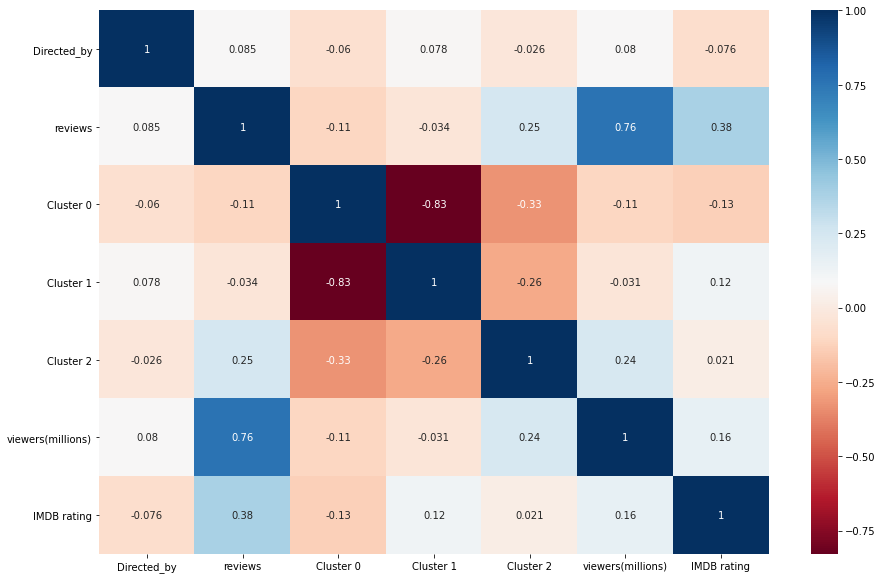

In [ ]:
#Heat map - pela correlação de pearson para o Dataframe normalizado
fig, ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(rescaled_dataset.corr(),ax=ax, annot=True, cmap='RdBu')

Mesmo com o dataset normalizado, não foi possível melhorar a correlação das variáveis com o que queremos predizer (nota_imdb). Vamos seguir na composição dos modelos para verificação.

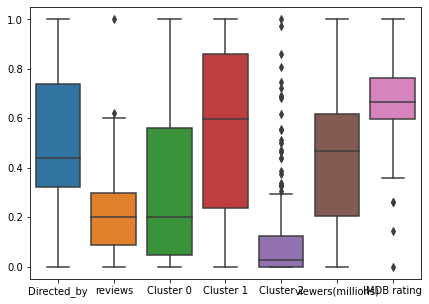

In [ ]:
fig, ax = plt.subplots(1, figsize= (7,5))
sns.boxplot(ax = ax, data = rescaled_dataset)

In [ ]:
from scipy.stats import norm, kurtosis
kurtosis(rescaled_dataset)

array([-0.87390838,  4.43295921, -0.76303953, -1.32622368,  4.3041759 ,
       -1.0224282 ,  2.35440014])

In [ ]:
from scipy.stats import skew
skew(rescaled_dataset)

array([ 0.16534667,  1.33550959,  0.84336431, -0.30507588,  2.18543373,
        0.01131822, -0.90079333])

In [ ]:
# separando os atributos e a classe do dataset
array = dataset.values
X = array[:,0:6]
Y = array[:,6]

# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
Y_pd = pd.DataFrame(Y, columns = ['IMDB rating'])

In [ ]:
dataset.head(20)

,Directed_by,reviews,Cluster 0,Cluster 1,Cluster 2,viewers(millions),IMDB rating
0,9.0,7572,0.287473,0.652349,0.060177,4.14,8.5
1,7.0,5731,0.735218,0.034977,0.229805,3.55,8.2
2,18.0,5367,0.025055,0.160141,0.814804,3.51,8.4
3,49.0,5071,0.100796,0.415217,0.483987,3.05,8.3
4,40.0,5011,0.755971,0.149650,0.094378,3.75,8.6
5,24.0,4749,0.020370,0.701274,0.278356,3.83,7.9
6,8.0,4664,0.013343,0.039799,0.946858,3.74,8.2
7,28.0,4539,0.040710,0.437651,0.521639,3.35,8.1
8,25.0,4353,0.240395,0.757118,0.000000,3.11,8.4
9,14.0,4454,0.018511,0.948825,0.032664,3.06,7.8


In [ ]:
Y_pd = Y_pd.reset_index()

In [ ]:
Y_pd.head()

,index,IMDB rating
0,0,8.5
1,1,8.2
2,2,8.4
3,3,8.3
4,4,8.6


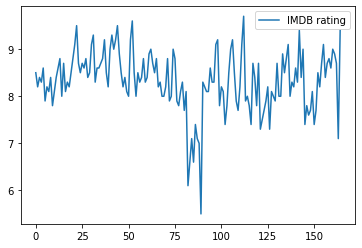

In [ ]:
#Visualizando a nota para ver se cria algum insigth na estratégia de modelo
Y_pd.plot(y= 'IMDB rating')

In [ ]:
#preciso fazer reshape do Y_train para que possa ser transformado em rescaledy
Y_train = np.reshape(Y_train, (-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler  
#Um scaler para cada (X e y), isso é necessário devido ao fato da transformada reversa de y ao fim
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

rescaledx = x_scaler.fit_transform(X_train) 
rescaledy = y_scaler.fit_transform(Y_train) 

##KNN

Para ambos X e Y não normalizados

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error 

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, Y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.7083912632282965
RMSE value for k=  2 is: 0.6469626002023654
RMSE value for k=  3 is: 0.643119501805608
RMSE value for k=  4 is: 0.6232703338768091
RMSE value for k=  5 is: 0.674199862463242
RMSE value for k=  6 is: 0.6532745799184877
RMSE value for k=  7 is: 0.6522829894533821
RMSE value for k=  8 is: 0.6385389632401122
RMSE value for k=  9 is: 0.6310846724675061
RMSE value for k=  10 is: 0.6279813739758575
RMSE value for k=  11 is: 0.6302142870351882
RMSE value for k=  12 is: 0.6216408042931942
RMSE value for k=  13 is: 0.6269584699778152
RMSE value for k=  14 is: 0.6366329273844196
RMSE value for k=  15 is: 0.6233298222771531
RMSE value for k=  16 is: 0.6231392756183658
RMSE value for k=  17 is: 0.6079236333336676
RMSE value for k=  18 is: 0.6125686627874914
RMSE value for k=  19 is: 0.6108919325415543
RMSE value for k=  20 is: 0.6130265207570673
RMSE value for k=  21 is: 0.6102082872124281
RMSE value for k=  22 is: 0.6065982463763697
RMSE value for k=  23

A normalização do Y de treinamento não beneficiou o resultado, predizendo até números negativos, será utilizado ox valores de X normalizados para o Y (nota IMDB) sem normalização

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error 

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(rescaledx, rescaledy)  #fit the model
    inputs = x_scaler.transform(X_test)
    pred = model.predict(inputs) #make prediction on test set
    pred = y_scaler.transform(pred)
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 9.464090457212773
RMSE value for k=  2 is: 9.467879838005999
RMSE value for k=  3 is: 9.467187318703848
RMSE value for k=  4 is: 9.466600828981507
RMSE value for k=  5 is: 9.46629322522628
RMSE value for k=  6 is: 9.46518270770998
RMSE value for k=  7 is: 9.465516652236754
RMSE value for k=  8 is: 9.465447877315778
RMSE value for k=  9 is: 9.465077104553465
RMSE value for k=  10 is: 9.465158948967318
RMSE value for k=  11 is: 9.465875595057534
RMSE value for k=  12 is: 9.46577856444092
RMSE value for k=  13 is: 9.466150996963325
RMSE value for k=  14 is: 9.466162258725564
RMSE value for k=  15 is: 9.466309762127967
RMSE value for k=  16 is: 9.466723245513068
RMSE value for k=  17 is: 9.466536435288369
RMSE value for k=  18 is: 9.465974218384606
RMSE value for k=  19 is: 9.46630010277769
RMSE value for k=  20 is: 9.4657895564715
RMSE value for k=  21 is: 9.465656316193888
RMSE value for k=  22 is: 9.464959821050225
RMSE value for k=  23 is: 9.464920589492923
RMS

Agora o teste foi com X normalizado e Y sem modificações

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error 

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(rescaledx, Y_train)  #fit the model
    inputs = x_scaler.transform(X_test)
    pred=model.predict(inputs) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.8436931799049828
RMSE value for k=  2 is: 0.6250454528926822
RMSE value for k=  3 is: 0.6448448773347863
RMSE value for k=  4 is: 0.5881886679381956
RMSE value for k=  5 is: 0.5973476729880535
RMSE value for k=  6 is: 0.5901905758523389
RMSE value for k=  7 is: 0.5759507211105863
RMSE value for k=  8 is: 0.5642061666490791
RMSE value for k=  9 is: 0.5774895681066273
RMSE value for k=  10 is: 0.5944439724344392
RMSE value for k=  11 is: 0.6012821262451166
RMSE value for k=  12 is: 0.5974306659968174
RMSE value for k=  13 is: 0.6169763795864032
RMSE value for k=  14 is: 0.6195560682511831
RMSE value for k=  15 is: 0.6287232533419845
RMSE value for k=  16 is: 0.6262619834938865
RMSE value for k=  17 is: 0.6228664958879196
RMSE value for k=  18 is: 0.6209530406063202
RMSE value for k=  19 is: 0.6146993445119107
RMSE value for k=  20 is: 0.6019677329518182
RMSE value for k=  21 is: 0.6048829002593642
RMSE value for k=  22 is: 0.599431548901275
RMSE value for k=  2

Resultados ligeiramente melhores do que não fazer normalização dos valores X

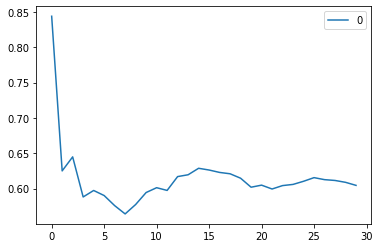

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Para KNN regressor, escolhido K = 8. foi feito a avaliação dos algoritmos ["auto", "ball_tree", "kd_tree", 'brute'] porém nenhuma mudança ocorreu na acurácia. O modelo de melhor acurácia tem um RMSE de 0,56, será apresentado os resultados do teste versus o real

Resultados das Previsões graficamente para KNN

In [ ]:
#Predição e treinamento para K = 8 
model_KNN = KNeighborsRegressor(n_neighbors = 8)
model_KNN.fit(rescaledx, Y_train)  #fit the model
inputs = x_scaler.transform(X_test)
pred_KNN=model_KNN.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_KNN)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5642061666490791


In [ ]:
len(X_test)

33

In [ ]:
#Criando um dummyDummy escolhido como 8.3 devido a mediana da população de nota de IMDB
dummy =[]
for i in range(33):
  dummy.append(8.3)

In [ ]:
#Erro dummy
error = sqrt(mean_squared_error(Y_test,dummy)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5954371961386478


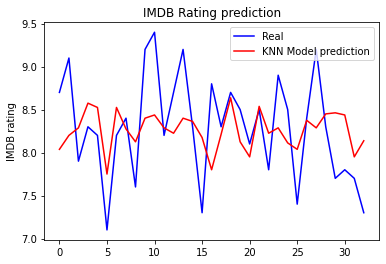

In [ ]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_KNN, color = 'red', label = 'KNN Model prediction')
#plt.plot(dummy, color = 'green', label = 'Constant 8.3')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

In [ ]:
(0.59-.52)/0.59

0.11864406779661009

## Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()

Teste com ambos sem nenhuma normalização

In [ ]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_linear, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.5796320036989587


In [ ]:
model_linear.fit(X_train,Y_train)
pred_linear=model_linear.predict(X_test) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5522745466846363


Teste com X normalizado e Y sem nenhuma normalização

In [ ]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_linear, rescaledx, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.5796320036989656


In [ ]:
model_linear.fit(rescaledx,Y_train)
inputs = x_scaler.transform(X_test)
pred_linear=model_linear.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.552274546684639


Nenhuma mudança significativa usando dados não normalizados ou normalizados.

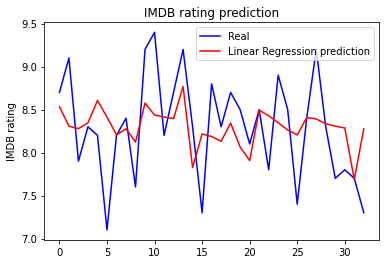

In [ ]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_linear, color = 'red', label = 'Linear Regression prediction')
plt.title('IMDB rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 45kB/s 


In [ ]:
import catboost as cb

In [ ]:
model_cat = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_cat, rescaledx, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

A saída de streaming foi truncada nas últimas 5000 linhas.
5:	learn: 0.6424674	total: 4.74ms	remaining: 785ms
6:	learn: 0.6385554	total: 5.53ms	remaining: 784ms
7:	learn: 0.6345716	total: 6.28ms	remaining: 779ms
8:	learn: 0.6310115	total: 7.02ms	remaining: 773ms
9:	learn: 0.6276074	total: 7.83ms	remaining: 775ms
10:	learn: 0.6241777	total: 8.55ms	remaining: 769ms
11:	learn: 0.6208232	total: 9.29ms	remaining: 765ms
12:	learn: 0.6173385	total: 10.1ms	remaining: 763ms
13:	learn: 0.6142305	total: 10.8ms	remaining: 762ms
14:	learn: 0.6109573	total: 11.6ms	remaining: 760ms
15:	learn: 0.6094797	total: 12.4ms	remaining: 763ms
16:	learn: 0.6060769	total: 13.2ms	remaining: 762ms
17:	learn: 0.6035797	total: 13.9ms	remaining: 759ms
18:	learn: 0.6001713	total: 14.7ms	remaining: 759ms
19:	learn: 0.5973996	total: 15.4ms	remaining: 757ms
20:	learn: 0.5943516	total: 16.2ms	remaining: 757ms
21:	learn: 0.5919515	total: 17ms	remaining: 757ms
22:	learn: 0.5893826	total: 17.8ms	remaining: 755ms
23:	learn: 0

In [ ]:
model_cat.fit(rescaledx,Y_train)
inputs = x_scaler.transform(X_test)
pred_cat=model_cat.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_cat)) #calculate rmse
print('RMSE =', error)

Learning rate set to 0.027218
0:	learn: 0.6435240	total: 747us	remaining: 746ms
1:	learn: 0.6393469	total: 1.39ms	remaining: 691ms
2:	learn: 0.6359906	total: 2.02ms	remaining: 672ms
3:	learn: 0.6317540	total: 2.59ms	remaining: 644ms
4:	learn: 0.6279529	total: 3.16ms	remaining: 630ms
5:	learn: 0.6238202	total: 3.77ms	remaining: 625ms
6:	learn: 0.6202726	total: 4.36ms	remaining: 618ms
7:	learn: 0.6163060	total: 4.96ms	remaining: 615ms
8:	learn: 0.6136198	total: 5.52ms	remaining: 608ms
9:	learn: 0.6106441	total: 6.09ms	remaining: 603ms
10:	learn: 0.6072428	total: 6.68ms	remaining: 601ms
11:	learn: 0.6042359	total: 7.29ms	remaining: 600ms
12:	learn: 0.6021859	total: 7.89ms	remaining: 599ms
13:	learn: 0.5989331	total: 8.51ms	remaining: 600ms
14:	learn: 0.5967710	total: 9.09ms	remaining: 597ms
15:	learn: 0.5932304	total: 9.68ms	remaining: 595ms
16:	learn: 0.5913771	total: 10.3ms	remaining: 594ms
17:	learn: 0.5881040	total: 10.9ms	remaining: 592ms
18:	learn: 0.5849671	total: 11.5ms	remaining:

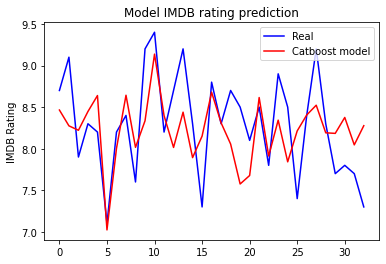

In [ ]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_cat, color = 'red', label = 'Catboost model')
plt.title('Model IMDB rating prediction')
plt.ylabel('IMDB Rating')
plt.legend()
plt.show()

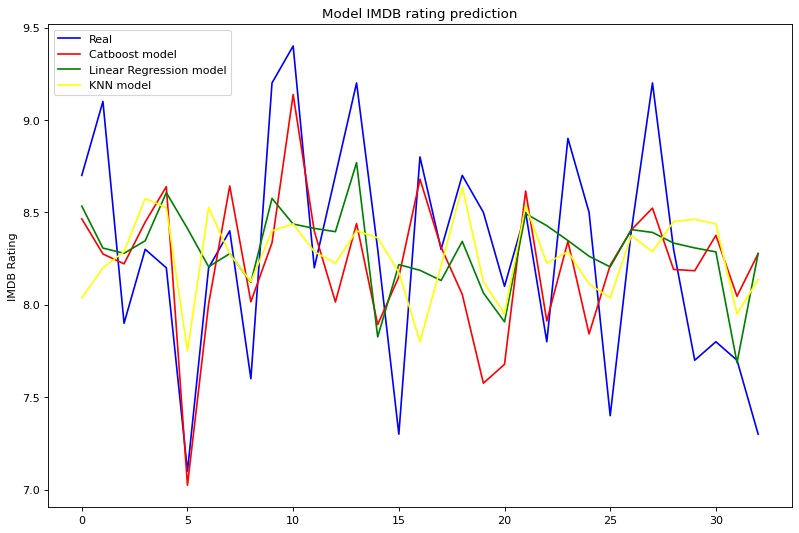

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_cat, color = 'red', label = 'Catboost model')
plt.plot(pred_linear, color = 'green', label = 'Linear Regression model')
plt.plot(pred_KNN, color = 'yellow', label = 'KNN model')
plt.title('Model IMDB rating prediction')
plt.ylabel('IMDB Rating')
plt.legend()
plt.show()

In [ ]:
print('KNN:', 'min:', min(pred_KNN), ', max:',  max(pred_KNN), 'variance: ', np.var(pred_KNN))
print('linear:', 'min:', min(pred_linear), ', max:',  max(pred_linear), 'variance: ', np.var(pred_linear))
print('Catboost:', 'min:', min(pred_cat), ', max:',  max(pred_cat), 'variance: ', np.var(pred_cat))

KNN: min: [7.75] , max: [8.6375] variance:  0.04597308310376492
linear: min: [7.68631285] , max: [8.76873387] variance:  0.045143192216795955
Catboost: min: 7.023629622992761 , max: 9.136953484050993 variance:  0.14017982391337247


In [ ]:
#não rodar, é apenas para saber quais parâmetros são tunaveis
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error

ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
#Era para ser utilizado para encontrar os melhores parâmetros mas demorou horas e não concluiu...
# ----- CATBOOST
learning_rate = np.arange(0.05, 0.17, 0.05)
max_depth =  np.arange(5, 12, 1)
colsample_bylevel = np.arange(0.3, 0.5, 0.1)
#param_grid = dict(criterion=criterios, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
param_grid = dict(max_depth=max_depth, colsample_bylevel=colsample_bylevel,learning_rate=learning_rate)
model = model
# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledx, Y_train)

# imprime o melhor resultado
print("Melhor CATBOOST: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

A saída de streaming foi truncada nas últimas 5000 linhas.
578:	learn: 0.0000006	total: 46.9s	remaining: 34.1s
579:	learn: 0.0000006	total: 46.9s	remaining: 34s
580:	learn: 0.0000005	total: 47.1s	remaining: 34s
581:	learn: 0.0000005	total: 47.1s	remaining: 33.8s
582:	learn: 0.0000005	total: 47.1s	remaining: 33.7s
583:	learn: 0.0000005	total: 47.3s	remaining: 33.7s
584:	learn: 0.0000005	total: 47.4s	remaining: 33.6s
585:	learn: 0.0000005	total: 47.4s	remaining: 33.5s
586:	learn: 0.0000005	total: 47.5s	remaining: 33.4s
587:	learn: 0.0000005	total: 47.6s	remaining: 33.3s
588:	learn: 0.0000004	total: 47.6s	remaining: 33.2s
589:	learn: 0.0000004	total: 47.7s	remaining: 33.1s
590:	learn: 0.0000004	total: 47.8s	remaining: 33.1s
591:	learn: 0.0000004	total: 47.9s	remaining: 33s
592:	learn: 0.0000004	total: 47.9s	remaining: 32.9s
593:	learn: 0.0000004	total: 48s	remaining: 32.8s
594:	learn: 0.0000004	total: 48.1s	remaining: 32.7s
595:	learn: 0.0000004	total: 48.1s	remaining: 32.6s
596:	learn: 0

KeyboardInterrupt: ignored

ANN

In [ ]:
from tensorflow.keras  import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Criando o objeto de rede neural (ANN)
myANN = Sequential()

In [ ]:
# Criando a camada de entrada (input layer) e a primeira camada oculta (hidden layer)
myANN.add( Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu', input_dim =6) )

In [ ]:
# Criando a camada hidden
myANN.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
myANN.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
myANN.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
myANN.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
myANN.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))

In [ ]:
# Criando a camada de saída (output layer)
myANN.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compilando a Rede
#loss = funcao de custo / objetivo
# optimizer = como ele vai utilizar a funcao de custo -> adam aprox. gradiente descendente
myANN.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Fiting ...t
myANN.fit(X_train, Y_train, batch_size = 10, epochs = 100)

Epoch 1/100
14/14 [==============================] - 0s 2ms/step - loss: 57.7124
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 54.1639
Epoch 13/100
14/14 [=====

In [ ]:
X_test

array([[2.00000000e+00, 4.35500000e+03, 7.74547577e-01, 1.65620133e-01,
        5.98322973e-02, 2.72000000e+00],
       [3.60000000e+01, 2.97700000e+03, 7.60599196e-01, 2.39004865e-01,
        0.00000000e+00, 1.44000000e+00],
       [3.70000000e+01, 1.88200000e+03, 1.27519548e-01, 8.59959960e-01,
        1.25204967e-02, 8.70000000e-01],
       [4.40000000e+01, 3.92100000e+03, 4.09949958e-01, 5.17772734e-01,
        7.22773522e-02, 2.52000000e+00],
       [2.40000000e+01, 5.09900000e+03, 5.57430863e-01, 3.17759067e-01,
        1.24810070e-01, 2.83000000e+00],
       [4.40000000e+01, 4.49400000e+03, 9.98898387e-01, 0.00000000e+00,
        0.00000000e+00, 2.24000000e+00],
       [3.50000000e+01, 3.28900000e+03, 3.21016073e-01, 5.69127500e-01,
        1.09856486e-01, 2.64000000e+00],
       [2.00000000e+00, 1.92900000e+03, 9.99553323e-01, 0.00000000e+00,
        0.00000000e+00, 7.70000000e-01],
       [4.50000000e+01, 1.44700000e+03, 1.32391555e-02, 9.86403167e-01,
        0.00000000e+00, 

In [ ]:
pred = myANN.predict(X_test)

In [ ]:
pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

XGBoost

In [ ]:
# Cria um array para armazenar os erros
distortions = []

# Cria modelos com k variando de 1 a 11, usando os mesmos parâmetros do modelo anterior
for i in range(1, 11):
    modelo = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    modelo.fit(X)
    distortions.append(modelo.inertia_) # inertia_ : Soma das distâncias quadráticas dos pontos ao centróide de cluster mais próximo.

# Configura e exibe o gráfico
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')
plt.show()

"# Cria um array para armazenar os erros\ndistortions = []\n\n# Cria modelos com k variando de 1 a 11, usando os mesmos parâmetros do modelo anterior\nfor i in range(1, 11):\n    modelo = KMeans(\n        n_clusters=i, init='random',\n        n_init=10, max_iter=300,\n        tol=1e-04, random_state=0\n    )\n    modelo.fit(X)\n    distortions.append(modelo.inertia_) # inertia_ : Soma das distâncias quadráticas dos pontos ao centróide de cluster mais próximo.\n\n# Configura e exibe o gráfico\nplt.plot(range(1, 11), distortions, marker='o')\nplt.xlabel('Número de clusters')\nplt.ylabel('Distorção')\nplt.show()\n"

### Ideal number of clusters = 3

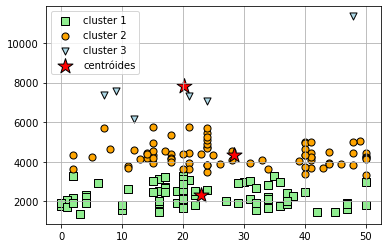

In [ ]:
# Criação do modelo
modelo = KMeans(
    n_clusters=3,   # número de clusters
    init='random',  # método de inicializaçãp
    n_init=10,      # número de execuções com diferentes centróides aleatórios para escolher o modelo final
    max_iter=300,   # número máximo de iterações para cada execução única
    tol=1e-04,      # = 0,0001 - controla a tolerância com relação às alterações no erro quadrático dentro do cluster para declarar convergência
    random_state=0  # semente
)

# Predição dos clusters
y_km = modelo.fit_predict(X)

# Plotagem dos 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# Plotagem dos centróides
plt.scatter(
    modelo.cluster_centers_[:, 0], modelo.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centróides'
)

# Legenda do gráfico
plt.legend(scatterpoints=1)

# Exibição do gráfico com clusters e centróides
plt.grid()
plt.show()

In [ ]:
# Imports
#import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# definindo a métrica de avaliação dos algoritmos
scoring = 'neg_mean_squared_error' 
# scoring = 'r2'

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

kfold = KFold(n_splits=10)

In [ ]:
model = DecisionTreeRegressor(random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.7507252747252748


In [ ]:
model = SVR()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.369637294038608


In [ ]:
model = KNeighborsRegressor()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.4209138461538461


In [ ]:
model = ElasticNet()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.36596167340800206


In [ ]:
model = Lasso()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.3656951063089046


In [ ]:
model = Ridge()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.3630818976130649


In [ ]:
model = LinearRegression()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean())) 

0.3777440864821123


LR: MSE 0.37 (0.34) - RMSE 0.61
Ridge: MSE 0.37 (0.35) - RMSE 0.61
Lasso: MSE 0.38 (0.32) - RMSE 0.62
ElasticNet: MSE 0.38 (0.32) - RMSE 0.62
KNN: MSE 0.45 (0.28) - RMSE 0.67
CART: MSE 0.78 (0.50) - RMSE 0.88
SVM: MSE 0.39 (0.33) - RMSE 0.63


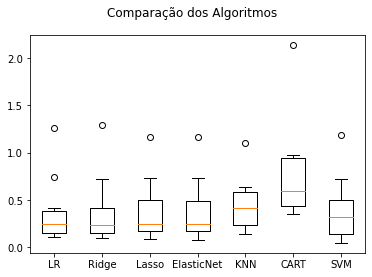

In [ ]:
# Lista de modelos a avaliar
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('SVM', SVR()))


# Treinamento e avaliação de cada modelo
results = []
names = []  
for name, model in models:
  kfold = KFold(n_splits=10)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(abs(cv_results))
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Comparação dos algoritmos em boxplot
fig = plt.figure()
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

ScaledLR: 0.377744 (0.257419)
ScaledRidge: 0.363898 (0.276477)
ScaledLasso: 0.425020 (0.221469)
ScaledElasticNet: 0.425020 (0.221469)
ScaledKNN: 0.373515 (0.198759)
ScaledCART: 0.750725 (0.572466)
ScaledSVM: 0.350500 (0.245394)


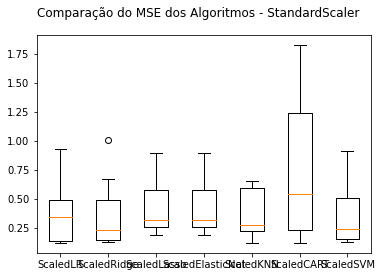

In [ ]:
# Pipelines para padronização do dataset e aplicação do modelo
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('Ridge', Ridge())])))
pipelines.append(('ScaledLasso', Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso())])))
pipelines.append(('ScaledElasticNet', Pipeline([('Scaler', StandardScaler()),('ElasticNet', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVR())])))
results = []
names = []

# Aplicação dos pipelines
for name, model in pipelines:
  kfold = KFold(n_splits=10)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(abs(cv_results))
  names.append(name)
  msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
  print(msg)

# boxplot de comparação dos algoritmos
fig = plt.figure() 
fig.suptitle('Comparação do MSE dos Algoritmos - StandardScaler') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

In [ ]:
# padronização dos dados
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

In [ ]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 50, 100]

# ----- Ridge
param_grid = dict(alpha=alphas)
model = Ridge()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor Ridge: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- Lasso
param_grid = dict(alpha=alphas)
model = Lasso()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor Lasso: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- ElasticNet
param_grid = dict(alpha=alphas)
model = ElasticNet()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor ElasticNet: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

Melhor Ridge: 0.359907 usando {'alpha': 0.01}
Melhor Lasso: 0.363126 usando {'alpha': 0.01}
Melhor ElasticNet: 0.363232 usando {'alpha': 0.01}


In [ ]:
# ----- KNN
k = [1,3,5,7,9,11,13,15,17,19,21]
distancias = ["euclidean", "manhattan", "minkowski"]
param_grid = dict(n_neighbors=k, metric=distancias)
model = KNeighborsRegressor()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor KNN: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- CART
criterios = ['mse', 'mae']
max_depth = [3,5,10,20,30,40,50]
min_samples_leaf = [3,5,10,20,30,40,50]
param_grid = dict(criterion=criterios, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
model = DecisionTreeRegressor(random_state=seed)

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor CART: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- SVM
c_values = [0.1, 0.5, 1.0, 1.5, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVR()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor SVM: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

Melhor KNN: 0.366160 usando {'metric': 'euclidean', 'n_neighbors': 5}
Melhor CART: 0.366821 usando {'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 40}
Melhor SVM: 0.347882 usando {'C': 1.0, 'kernel': 'rbf'}


# Modelo final


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# padronização os dados de treino
# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)

# criando e treinando um modelo com a melhor configuração até o momento
model = DecisionTreeRegressor(random_state=seed,criterion= 'mse', max_depth= 3, min_samples_leaf= 40)
model.fit(X, Y_train)

# padronização dos dados de teste
# rescaledTestX = scaler.transform(X_test)

# predições
predictions = model.predict(X_test)

# estimando o MSE e R2 no conjunto de teste
print(mean_squared_error(Y_test, predictions))
print(r2_score(Y_test, predictions))

ValueError: Number of labels=132 does not match number of samples=165

In [ ]:
model = DecisionTreeRegressor(random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.7507252747252748
